In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [4]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [5]:
import os
os.chmod("kaggle.json", 600)

In [6]:
# Downloading data
!kaggle datasets download -d kazanova/sentiment140

100% 80.9M/80.9M [00:01<00:00, 37.6MB/s]



In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.4.1


In [9]:
df = pd.read_csv('sentiment140.zip', compression='zip', sep=',', quotechar='"', encoding ='latin' , header= None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [12]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [13]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

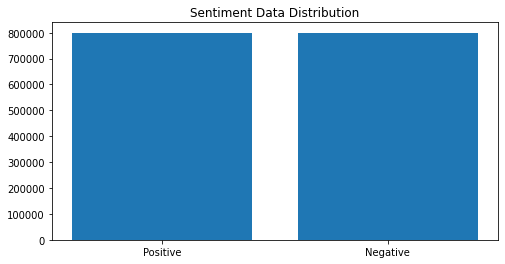

In [14]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [15]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
676501,Negative,is thristy... agua!!! http://plurk.com/p/12blz1
415109,Negative,Cloudy Sunday....Humid Weather....so GLOOMY fo...
1211600,Positive,i wear man i luvz dat push play promo rap vide...
1021248,Positive,wishes she could tweet daily specials for Phil...
130788,Negative,ARRGGGHHHH I have loaddss of birthday money bu...
1559175,Positive,@ShontelSherrea well atleast she's going to do...
47009,Negative,I dropped my DSi yesterday when trying to put ...
112997,Negative,afternoon twitter world. i am hungry x
1074600,Positive,"Taco bell, hanging w/Ryan then to Megans house..."
173955,Negative,i hate going to work.


In [16]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [17]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [18]:
df.text = df.text.apply(lambda x: preprocess(x))

In [19]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [20]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [21]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


In [22]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [23]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [25]:
labels = train_data.sentiment.unique().tolist()

In [27]:
print(labels)

['Negative', 'Positive']


In [75]:
labels[1]

'Positive'

In [28]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [30]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-05-11 15:28:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-11 15:28:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-11 15:28:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [31]:
GLOVE_EMB = '/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'


In [33]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.50d.txt  kaggle.json
glove.6B.200d.txt  glove.6B.zip      sample_data
glove.6B.300d.txt  glove.6B.zip.1    sentiment140.zip
/content


In [35]:
embeddings_index = {}

f = open('glove.6B.300d.txt')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [36]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [37]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

Model Training - LSTM
---
We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As you can see in the word cloud, the some words are predominantly feature in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use Sequence Models.

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.

For model architecture, we use

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) Conv1D Layer - Its using to convolve data into smaller feature vectors.

3) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) Dense - Fully Connected Layers for classification

In [38]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [39]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

Optimization Algorithm
---
This notebook uses Adam, optimization algorithm for Gradient Descent. You can learn more about Adam here

Callbacks
---
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

<b>LRScheduler</b> - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

<b>ModelCheckPoint</b> - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [40]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [41]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 256s 178ms/step - loss: 0.5464 - accuracy: 0.7164 - val_loss: 0.4830 - val_accuracy: 0.7647
Epoch 2/10
1250/1250 [==============================] - 222s 177ms/step - loss: 0.4896 - accuracy: 0.7612 - val_loss: 0.4729 - val_accuracy: 0.7725
Epoch 3/10
1250/1250 [==============================] - 222s 178ms/step - loss: 0.4773 - accuracy: 0.7692 - val_loss: 0.4661 - val_accuracy: 0.7766
Epoch 4/10
1250/1250 [==============================] - 222s 178ms/step - loss: 0.4702 - accuracy: 0.7733 - val_loss: 0.4633 - val_accuracy: 0.7780
Epoch 5/10
1250/1250 [==============================] - 222s 177ms/step - loss: 0.4662 - accuracy: 0.7763 - val_loss: 0.4623 - val_accuracy: 0.7793
Epoch 6/10
1250/1250 [==============================] - 221s 177ms/step - loss: 0.4623 - accuracy: 0.7782 - val_loss: 0.4634 - val_accuracy: 0.7799
Epoch 7/10
1250/1250 [==============================] - 219s 175ms/step - loss: 0.4585 - accuracy: 0.7805 - val_

Model Evaluation
---
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

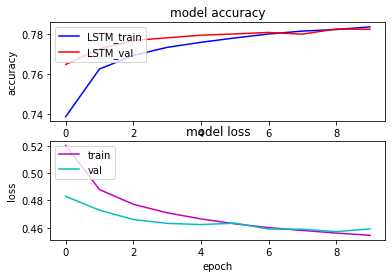

In [42]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as POSITIVE sentiment.

In [43]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 9s 226ms/step


In [44]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


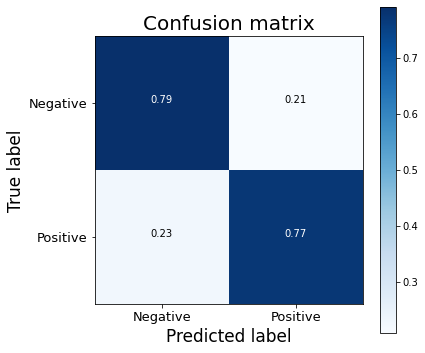

In [45]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [46]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.79      0.78    160542
    Positive       0.79      0.77      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [48]:
GLOVE_EMB = 'glove.6B.300d.txt'

In [50]:
# EXPORT
KERAS_MODEL_04 = "model.h5"


In [57]:
TOKENIZER_MODEL_04 = "tokenizer.pkl"
ENCODER_MODEL_04 = "encoder.pkl"

In [52]:
#Save model
model.save('KERAS_MODEL_04')

INFO:tensorflow:Assets written to: KERAS_MODEL_04/assets


In [58]:
import pickle
pickle.dump(tokenizer, open(TOKENIZER_MODEL_04, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL_04, "wb"), protocol=0)

In [62]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [96]:
neutral = df.sentiment.value_counts
neutral

<bound method IndexOpsMixin.value_counts of 0          Negative
1          Negative
2          Negative
3          Negative
4          Negative
             ...   
1599995    Positive
1599996    Positive
1599997    Positive
1599998    Positive
1599999    Positive
Name: sentiment, Length: 1600000, dtype: object>

In [148]:
#Predict
SENTIMENT_THRESHOLDS = (0.2, 0.7)
def decode_sentiment(score, include_neutral=True):
    label = ["Negative", "Positive","Neutral"]
    if include_neutral:
      if score <= SENTIMENT_THRESHOLDS[0]:
        label = label[0]
        return label
      elif score >= SENTIMENT_THRESHOLDS[1]:
        label = label[1]
        return label
      else:
        return label[2]

In [149]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [150]:
predict("I love the music")

{'elapsed_time': 0.0643310546875,
 'label': 'Positive',
 'score': 0.9622169137001038}

In [151]:
predict("I hate the rain")

{'elapsed_time': 0.06743288040161133,
 'label': 'Negative',
 'score': 0.011905509978532791}

In [152]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.06097912788391113,
 'label': 'Neutral',
 'score': 0.3511227071285248}

In [153]:
predict("i must appreciate your terrible try!")

{'elapsed_time': 0.06274533271789551,
 'label': 'Neutral',
 'score': 0.2962953746318817}

In [154]:
predict("i expect this result to be better!")

{'elapsed_time': 0.0596156120300293,
 'label': 'Positive',
 'score': 0.7943100333213806}

In [155]:
predict("i am extremely positive about this model")

{'elapsed_time': 0.06609940528869629,
 'label': 'Positive',
 'score': 0.8825520873069763}

In [157]:
predict("i am happy and i am emotional too")

{'elapsed_time': 0.06196856498718262,
 'label': 'Neutral',
 'score': 0.4346054792404175}

In [158]:
predict("yes, we did it!")

{'elapsed_time': 0.06133604049682617,
 'label': 'Positive',
 'score': 0.8022045493125916}

In [159]:
predict("@karishma ott is apt")

{'elapsed_time': 0.06718564033508301,
 'label': 'Neutral',
 'score': 0.5784636735916138}

In [174]:
predict("@karishma outfit of the day is appropriate")

{'elapsed_time': 0.06774163246154785,
 'label': 'Positive',
 'score': 0.8568690419197083}

In [172]:
predict("WTF is this your model")

{'elapsed_time': 0.061324357986450195,
 'label': 'Neutral',
 'score': 0.2672094702720642}

In [169]:
predict("Covid-19 affected all of us")

{'elapsed_time': 0.06743121147155762,
 'label': 'Negative',
 'score': 0.1236468106508255}

In [175]:
predict("Covid-19 pandemic affected all of us")

{'elapsed_time': 0.06368041038513184,
 'label': 'Neutral',
 'score': 0.2246607095003128}

In [166]:
predict("everyone should get vaccinated")

{'elapsed_time': 0.0679175853729248,
 'label': 'Negative',
 'score': 0.156111940741539}

In [165]:
predict("everyone should get vaccinated as a remedy")

{'elapsed_time': 0.07025551795959473,
 'label': 'Neutral',
 'score': 0.3132949769496918}

Sentiment Analysis Challenge No. 1: Sarcasm Detection
----
Model is giving neutral results to sarcasm.

In [176]:
predict("This phone has an awesome battery back-up of 2 hours.") //sarcastic

{'elapsed_time': 0.07855463027954102,
 'label': 'Neutral',
 'score': 0.25207725167274475}

In [177]:
predict("It's -25 outside and I am so hot.")  //sarcastic

{'elapsed_time': 0.06573247909545898,
 'label': 'Neutral',
 'score': 0.2727428674697876}

In [178]:
predict("We drove so slowly---only 160 km/h.") //sarcastic

{'elapsed_time': 0.062149763107299805,
 'label': 'Neutral',
 'score': 0.6361349821090698}

Sentiment Analysis Challenge No. 2: Negation Detection
---
Instead of negative or neutral, model gives positive for negation. Drawback found.

In [179]:
predict("with this act, it will be his first and last movie")       #drawback with negation
#—it carries a negative sentiment, but no negative words are used.

{'elapsed_time': 0.06988000869750977,
 'label': 'Positive',
 'score': 0.7589401602745056}

Sentiment Analysis Challenge No. 3: Word Ambiguity
---
These two examples show how context affects opinion word sentiment. In the first example, the word polarity of “unpredictable” is predicted as positive. In the second, the same word’s polarity is negative.

However, model gives neutral for both, still acceptable.

In [181]:
predict("The story is unpredictable.")

{'elapsed_time': 0.06344747543334961,
 'label': 'Neutral',
 'score': 0.4598727524280548}

In [182]:
predict("The steering wheel is unpredictable.")

{'elapsed_time': 0.06110525131225586,
 'label': 'Neutral',
 'score': 0.25072094798088074}

Sentiment Analysis Challenge No. 4: Multipolarity
---
Let’s consider an example which consists of multiple polarities: “The audio quality of my new laptop is so cool but the display colors are not too good.”

#drawback

In [183]:
predict("The audio quality of my new laptop is so cool but the display colors are not too good.")

{'elapsed_time': 0.06482243537902832,
 'label': 'Positive',
 'score': 0.8220648765563965}